# SIMPLE WORKING VERSION

Karan suggests to use KFold:

*The best way to improve the test loss is to combine first both train and dev dataset. Then use kfold random sampling while training. Note: LSTM is not capable enough too perform best on unseen data. If you evaluate the train and test set there will be no similarity in que and answer. So its best, if you use kfold method, which randomly select test set at each iteration.* 
- *Try reducing sentence length (both que and answer)*
- *Try using learning-rate as 0.01*
- *Try reducing the batch size (keep 16 as batch size)*
- *Try adding n-layer paramter in LSTM to at least 2*
- *Try to train for at least 30 epochs.*

There is an example that uses KFold: https://github.com/iJoud/Seq2Seq-Chatbot/tree/main


# RNN LSTM Chatbot project

In this project I'm creating a chatbot that is supposed to answer questions from the Stanford Questions & Answers dataset SQuAD1, using a sequence-to-sequence Encoder-Decoder recurrent neural network architecture in PyTorch.

To make the notebook more readable and the code more modular, all helper functions (data ingestion and preparation, data analysis, vocabulary creation) were moved to `modules`. 

The model for easier debugging is kept in the main notebook for now.



In [1]:
import torch

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda:0'

In [4]:
from torchtext.datasets import SQuAD1

In [5]:
train, test = SQuAD1("root")

In [6]:
from modules.data import *

#get_dataframe,  get_pairs_from_df, cols, sample_df_perc, get_thresholds, get_outliers, tokenize_sentence, remove_least_common, to_tensor,  filter_sentences

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package wordnet to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data ingestion

* Data is loaded from the dataset into pandas dataframes: one for training, one for testing, 
* To keep the dataset size reasonable, only a sample of the questions/answers is taken

In [7]:
# get train and test dataframes of sentences
train_df, test_df = get_dataframe(train), get_dataframe(test)

In [8]:
train_df.shape, test_df.shape

((87599, 2), (10570, 2))

train_len = 30000
test_len = 3000

train_df = sample_df_num(train_df, train_len)

test_df = sample_df_num(test_df, test_len)

In [9]:
train_df.shape, test_df.shape

((87599, 2), (10570, 2))

In [10]:
train_df.head(3)

,Question,Answer
0,To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous
1,What is in front of the Notre Dame Main Building?,a copper statue of Christ
2,The Basilica of the Sacred heart at Notre Dame...,the Main Building


## Vocabulary creation / Data preparation

Sentences (questions and answers) are converted into lists of tokens:
* all characters are made into lower case
* punctuation is removed
* stopwords (most common words that don't carry much additional meaning) are removed, but keeping question words (when, how, who, etc.)
* For questions stemming is applied to reduce number of words to just their "roots". For answers this step is skipped, to have full unstemmed words in the answers vocabulary
* Pairs question:answer are created from both train and test dataset, and words are added to two vocabularies: Q_vocab and A_vocab

In [11]:
# Example of the sequence processing

import random

rand_question = train_df.at[random.randint(0,train_df.shape[0]), 'Question']
print(rand_question)

print(tokenize_sentence(rand_question))
print(tokenize_sentence(rand_question, normalization='stem'))

Which of Popper's works addresses the improvement of scientific understanding of the world over time?
['which', 'poppers', 'works', 'addresses', 'improvement', 'scientific', 'understanding', 'world', 'time']
['which', 'popper', 'work', 'address', 'improv', 'scientif', 'understand', 'world', 'time']


In [12]:
from modules.vocab import Vocab

In [13]:
for col, norm in zip(cols, ['stem', None]): # only questions get stemmed
    train_df[f'{col}_tokens'] = train_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [14]:
for col, norm in zip(cols, ['stem', None]):
    test_df[f'{col}_tokens'] = test_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [15]:
train_df.sample(3)

,Question,Answer,Question_tokens,Answer_tokens
22058,"When were terms such as ""Near East"", ""Far East...",the 20th century,"[when, term, near, east, far, east, middl, eas...","[20th, century]"
46782,When was Madonna awarded the accolade?,2003,"[when, madonna, award, accolad]",[2003]
68988,When did Kerry speak to the OAS?,in November 2013,"[when, kerri, speak, oa]","[november, 2013]"


In [16]:
# processed sequences columns names have '_tokens' suffix
cols_tokens = [f'{col}_tokens' for col in cols]

### Create pairs and add to the vocabularies

In [17]:
train_pairs = get_pairs_from_df(train_df, cols_tokens)

In [18]:
test_pairs = get_pairs_from_df(test_df, cols_tokens)

In [19]:
Q_vocab, A_vocab = Vocab(), Vocab()

### Words from both training and test datasets are added to the two vocabularies

In [20]:
for pair in train_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [21]:
Q_vocab.n_words, A_vocab.n_words, 

(28676, 41545)

In [22]:
for pair in test_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [23]:
# Answers vocabulary contains more words due to lack of stemming

Q_vocab.n_words, A_vocab.n_words 

(30679, 44438)

## Data analysis and further cleanup

To improve and reduce the dataset, some analysis is done to find and remove outliers:
* least common words (those that occur only once)
* answers that have less than one token (empty sequences)
* questions that have less than three tokens, as they're not really meaningful
* histograms are used to find the "long tail" of the dataset: longer sequences are rare, so I establish a threshold above which the dataframe row with either very long question or answer is dropped. This way most of the data is kept, and the sequences can be of reasonable length

In [24]:
from modules.stats import sentences_stats, histograms

In [25]:
# statistics for tokenized sentences
sentences_stats(train_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.44
	         median: 6.00
	         minimum: 0
	         maximum: 32)
Sentences in column Answer_tokens:
	         mean: 2.43
	         median: 2.00
	         minimum: 0
	         maximum: 22)


In [26]:
# statistics for tokenized sentences
sentences_stats(test_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.52
	         median: 6.00
	         minimum: 2
	         maximum: 19)
Sentences in column Answer_tokens:
	         mean: 2.35
	         median: 2.00
	         minimum: 0
	         maximum: 18)


### Remove the least common words from the sentences

In [27]:
# how many times at most a word occurs to be considered an outlier
outlier_threshold = 1

In [28]:
print(f'Questions vocabulary has {len(get_outliers(Q_vocab, outlier_threshold+1))} words that occur only once, answers vocabulary has {len(get_outliers(A_vocab, outlier_threshold+1))} such words')

Questions vocabulary has 14030 words that occur only once, answers vocabulary has 23723 such words


### Create lists of those words and remove them from the sequences

In [29]:
q_outliers, a_outliers = get_outliers(Q_vocab,outlier_threshold+1), get_outliers(A_vocab,outlier_threshold+1)

In [30]:
train_df_final = remove_least_common(train_df, cols_tokens, [q_outliers, a_outliers])

In [31]:
test_df_final = remove_least_common(test_df, cols_tokens, [q_outliers, a_outliers])

In [32]:
# tokenized & least common removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.29
	         median: 6.00
	         minimum: 0
	         maximum: 32)
Sentences in column Answer_tokens:
	         mean: 2.19
	         median: 2.00
	         minimum: 0
	         maximum: 22)


In [33]:
# tokenized & least common removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.38
	         median: 6.00
	         minimum: 1
	         maximum: 19)
Sentences in column Answer_tokens:
	         mean: 2.13
	         median: 2.00
	         minimum: 0
	         maximum: 18)


### Remove questions that have less than three words and answers that have less than one

In [35]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


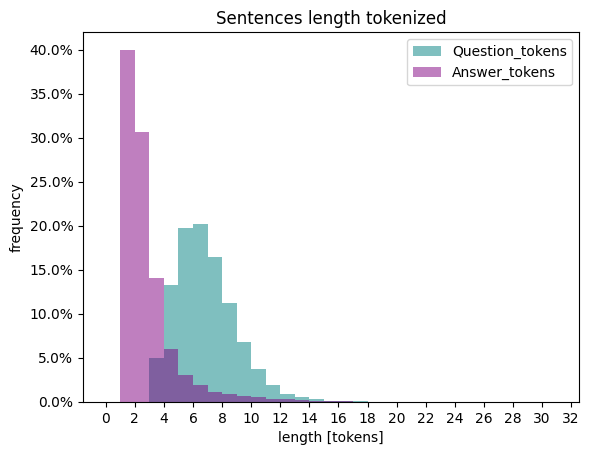

In [36]:
# display the histograms to see if that worked

train_df_final_thresholds = histograms(train_df_final, cols_tokens, name = 'tokenized')

In [37]:
train_df_final.shape

(80199, 4)

In [38]:
# shortest sentences removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.36
	         median: 6.00
	         minimum: 3
	         maximum: 32)
Sentences in column Answer_tokens:
	         mean: 2.35
	         median: 2.00
	         minimum: 1
	         maximum: 22)


In [39]:
test_df_final = filter_sentences(test_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


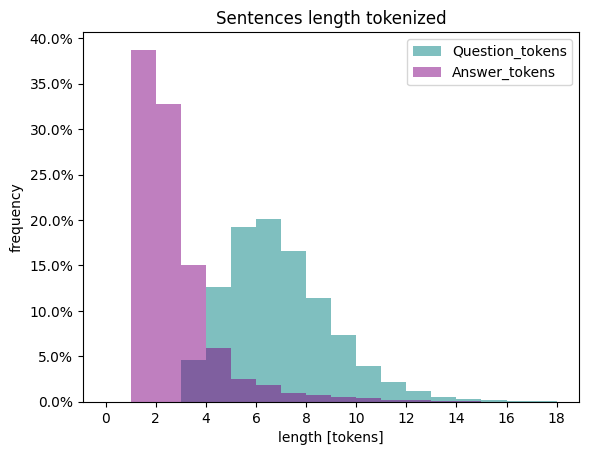

In [40]:
# display the histograms to see if that worked

test_df_final_thresholds = histograms(test_df_final, cols_tokens, name = 'tokenized')

In [41]:
test_df_final.shape

(9781, 4)

In [42]:
# shortest sentences removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.45
	         median: 6.00
	         minimum: 3
	         maximum: 19)
Sentences in column Answer_tokens:
	         mean: 2.25
	         median: 2.00
	         minimum: 1
	         maximum: 18)


### Remove long outliers: long sentences that occure rarely

In [43]:
# keeping only the 95% of the data
cutoff = 95

In [44]:
get_thresholds(train_df_final_thresholds, cutoff = cutoff)

{'Question_tokens': 10, 'Answer_tokens': 6}

In [45]:
Q_MAX, A_MAX = get_thresholds(train_df_final_thresholds, cutoff = cutoff).values()

In [46]:
Q_MAX, A_MAX

(10, 6)

In [49]:
Q_MAX = 8
A_MAX = 4

In [50]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [51]:
# long outliers removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 5.77
	         median: 6.00
	         minimum: 3
	         maximum: 8)
Sentences in column Answer_tokens:
	         mean: 1.86
	         median: 2.00
	         minimum: 1
	         maximum: 4)


In [50]:
# to simplify I'm using the same thresholds for the test set

In [52]:
test_df_final = filter_sentences(test_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [53]:
# long outliers removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 5.82
	         median: 6.00
	         minimum: 3
	         maximum: 8)
Sentences in column Answer_tokens:
	         mean: 1.88
	         median: 2.00
	         minimum: 1
	         maximum: 4)


In [54]:
train_df_final.shape, test_df_final.shape

((62140, 4), (7588, 4))

### Pairs have to be redone from the cleaned up datasets, to be used in the model (after being turned into tensors).

In [55]:
train_pairs_final = get_pairs_from_df(train_df_final, cols_tokens)

In [56]:
test_pairs_final = get_pairs_from_df(test_df_final, cols_tokens)

In [57]:
len(train_pairs_final), len(test_pairs_final)

(62140, 7588)

### Data preparation for the neural network model

Sequences are converted into torch tokens made of their vocabulary indexes. Sequences shorter than the defined length are padded at the beginning. Also Start-Of-Sequence and End-Of-Sequence tokens are added to the tensor.

The padding token will be ignored by the model.

### Neural network model

It uses Seq2Seq Encoder-Decoder architecture with a single LSTM layer. Right now the training is done pair after pair, without batch processing.
The optimizer is Stochastic Gradient Descent, and the loss function is 
negative log likelihood (NLLLoss)



In [58]:
import torch
import torch.nn as nn

## ENCODER

In [59]:
class Encoder(nn.Module):
    
    # We initialize the Encoder object with appropriate layers

    def __init__(self, input_size, hidden_size, embedding_size):
        
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.embedding_size = embedding_size

        # embedding step
        self.embedding = nn.Embedding(self.input_size, self.embedding_size).to(device)
        
        # single LSTM layer
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, 1).to(device)
    
    def forward(self, x, hidden, cell_state):
        x = self.embedding(x)        
        x = x.view(1, 1, -1)        
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        return x, hidden, cell_state

## DECODER

In [60]:
class Decoder(nn.Module):

    # The Decoder is initialized in the same manner.

    def __init__(self, hidden_size, output_size, embedding_size):

        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding_size = embedding_size

        # embedding
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        # single LSTM layer
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size)
        
        # fully connected linear layer
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        
        # softmax
        self.softmax = nn.LogSoftmax(dim=1)     

    def forward(self, x, hidden, cell_state):
        
        x = self.embedding(x)
        x = x.view(1, 1, -1)
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        x = self.softmax(self.fc(x[0]))
        return x, hidden, cell_state

## SEQ2SEQ

In [61]:
class Seq2Seq(nn.Module):

    def __init__(self, input_size, hidden_size, embedding_size, output_size, device):    

        super(Seq2Seq, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        
        # make encoder and decoder 
        self.encoder = Encoder(self.input_size, self.hidden_size, self.embedding_size).to(device)
        self.decoder = Decoder(self.hidden_size, self.output_size, self.embedding_size).to(device)
                
    def forward(self, src_batch: torch.LongTensor, trg_batch: torch.LongTensor, src_len, trg_len, teacher_forcing_ratio: float = 0.5):
        
        # target batch (answers) is unpacked to maximum length and batch size
        max_len, batch_size = trg_batch.shape               

        trg_vocab_size = self.decoder.output_size
        
        # tensor to store decoder's output
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(device) #.to(self.device) 
              
        # initialize hidden and cell state
        encoder_hidden = torch.zeros([1, 1, self.hidden_size]).to(device) 
        cell_state = torch.zeros([1, 1, self.hidden_size]).to(device)
       
        # iterate over the length of the source (question sequence) using the encoder
        
        for i in range(src_len):       
            # last hidden & cell state of the encoder is used as the decoder's initial hidden state
            
            # src_batch[i] is the ith token of the input (question)
            _, hidden, cell = self.encoder(src_batch[i], encoder_hidden, cell_state)
        
        # trg_batch[0] that's just the first element of trg_batch        
        trg = trg_batch[0]
                
        # now iterating over the target length, using the decoder
        
        for i in range(trg_len):
            prediction, hidden, cell = self.decoder(trg, hidden, cell)
            
            # here we use the teacher forcing: if the random value is less than the ratio, then the target is just an element of the target (token from the answer)
            # otherwise it's the highest probability prediction
            outputs[i] = prediction
            
            if random.random() < teacher_forcing_ratio:
                trg = trg_batch[i]
            else:
                trg = prediction.argmax(1)
                
        return outputs

### Model parameters

In [62]:
embedding_dim = 256
hidden_size = 256

### Hyperparameters

In [63]:
learning_rate = 0.01
num_epochs = 30

### Model

In [64]:
seq2seq = Seq2Seq(input_size=Q_vocab.n_words, hidden_size=hidden_size, embedding_size=embedding_dim, output_size=A_vocab.n_words, device=device)

In [65]:
seq2seq = seq2seq.to(device)

In [66]:
print(seq2seq)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(30679, 256)
    (lstm): LSTM(256, 256)
  )
  (decoder): Decoder(
    (embedding): Embedding(44438, 256)
    (lstm): LSTM(256, 256)
    (fc): Linear(in_features=256, out_features=44438, bias=True)
    (softmax): LogSoftmax(dim=1)
  )
)


### Optimizer and loss function

In [67]:
from torch import optim
import torch.nn as nn

In [68]:
optimizer = optim.SGD(seq2seq.parameters(), lr=learning_rate)
criterion = nn.NLLLoss(ignore_index=0).to(device) # 0 is padding

### Model training 

For debugging purposes the training function is kept in the main notebook for now.

In [69]:
total_train_loss = []
total_test_loss = []

In [70]:
def train(model, pairs, optimizer, criterion, device, teacher_forcing_ratio = 0.5, print_every = 1000): 
    
    model.train() # Set the model to training mode

    total_loss = 0

    count = 0

    for pair in pairs:

        src = pair.question
        tgt = pair.answer

        src_tensor = to_tensor(vocab=Q_vocab, tokens=src, seq_len=Q_MAX, device=device)#.to(device) #.unsqueeze(0)
        tgt_tensor = to_tensor(vocab=A_vocab, tokens=tgt, seq_len=A_MAX, device=device)#.to(device) #.unsqueeze(0)

        # print(src_tensor.shape, tgt_tensor.shape)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        output = model(src_tensor, tgt_tensor, src_len=src_tensor.size(0), trg_len=tgt_tensor.size(0), teacher_forcing_ratio=teacher_forcing_ratio)

        # Compute the loss
        loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        count += 1 

        if count % print_every == 0:
            print(f'Loss {total_loss/count}')

    return total_loss / len(pairs)

In [71]:
def evaluate(model, pairs, criterion, device):
    
    model.eval()
    
    total_loss = 0
    
    with torch.no_grad():
    
        for pair in pairs:
            
            src = pair.question
            tgt = pair.answer
            
            src_tensor = to_tensor(vocab=Q_vocab, tokens=src, seq_len=Q_MAX, device=device)#.to(device) #.unsqueeze(0)
            tgt_tensor = to_tensor(vocab=A_vocab, tokens=tgt, seq_len=A_MAX, device=device)#.to(device) #.unsqueeze(0)

            output = model(src_tensor, tgt_tensor, src_len=src_tensor.size(0), trg_len=tgt_tensor.size(0), teacher_forcing_ratio=0) # turn off teacher forcing

            # Compute the loss
            loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))

            
            total_loss += loss.item()
        
    return total_loss / len(pairs)

In [72]:
import matplotlib.pyplot as plt

In [73]:
for epoch in range(num_epochs):
    train_loss = train(seq2seq, train_pairs_final, optimizer, criterion, device)
    test_loss = evaluate(seq2seq, test_pairs_final, criterion, device)    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    
    total_train_loss.append(train_loss)
    total_test_loss.append(test_loss)



Loss 6.138925907373428
Loss 5.665556329607964
Loss 5.422191146572431
Loss 5.274101310282946
Loss 5.1777826576948165
Loss 5.060412658294042
Loss 5.024915111592838
Loss 4.988384833216667
Loss 4.927239915808042
Loss 4.883971033763886
Loss 4.839784553755414
Loss 4.798760089387496
Loss 4.771627730800556
Loss 4.745397167384625
Loss 4.708552335500717
Loss 4.699005514301359
Loss 4.673108266136225
Loss 4.649730131685734
Loss 4.64802007442399
Loss 4.638342442634702
Loss 4.621480358756724
Loss 4.619393641160293
Loss 4.6055101600885395
Loss 4.599667688459158
Loss 4.592523946399688
Loss 4.585663975261725
Loss 4.582873447784671
Loss 4.573222222017391
Loss 4.5600896535145825
Loss 4.553379962998629
Loss 4.549003374466973
Loss 4.548034676002339
Loss 4.545192748364174
Loss 4.535138930808095
Loss 4.536200982551915
Loss 4.53194768034584
Loss 4.527945615844146
Loss 4.522653424562592
Loss 4.527179853190214
Loss 4.523953871430456
Loss 4.522294710326485
Loss 4.5206683866282305
Loss 4.516756220513998
Loss 4.51

KeyboardInterrupt: 

### stopped after 23 epochs, doesn't seem to converge

In [74]:
N_EPOCHS = 23

Text(0, 0.5, 'loss')

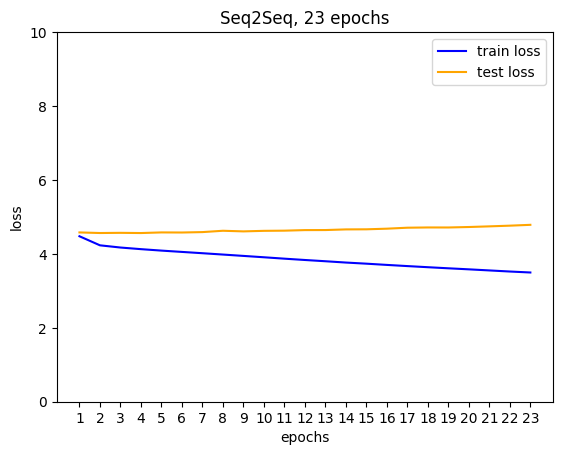

In [75]:
fig, ax = plt.subplots()
ax.plot(range(1, N_EPOCHS+1), total_train_loss, color = 'blue', label = 'train loss')
ax.plot(range(1, N_EPOCHS+1), total_test_loss, color = 'orange', label = 'test loss')
ax.legend()
ax.set_title(f'Seq2Seq, {N_EPOCHS} epochs')
ax.set_xticks(range(1, N_EPOCHS+1))
ax.set_ylim(0,10)
ax.set_xlabel('epochs')
ax.set_ylabel('loss')